# 1. Linear Regression

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

%matplotlib inline
plt.style.use('seaborn-white')

In [3]:
# https://taqm.epa.gov.tw/taqm/tw/HourlyData.aspx
raw_data = pd.read_csv('./data_Hsinchu.csv',
                 usecols=[0] + list(range(2, 27)),
                 na_values=['#', '*', 'x', 'NA', 'NR'],
                 encoding='big5').fillna(0)
data = raw_data.pivot(index='測項', columns='日期').T

$X=\begin{pmatrix} 1 & x_1 & \cdots & x_p \end{pmatrix}$

In [4]:
# append 'Intercept' column
Xpred = list(data.columns)
Xpred.remove('PM2.5')
Xcols = ['Intercept'] + Xpred

n = data.shape[0]
p = len(Xpred)
data = data.assign(Intercept=np.ones(n))

$y=X\hat\beta$

In [5]:
X = data[Xcols]
y = data[['PM2.5']]

### Coefficient
$\hat\beta=(X^tX)^{-1}X^ty$

In [6]:
invXtX = np.linalg.inv(np.dot(X.T, X))
beta_hat = np.dot(np.dot(invXtX, X.T), y)
beta_hat_v = beta_hat.reshape(18)

### Std. Error
$RSS=\displaystyle\sum_{i=1}^n(y_i-\hat y_i))^2$

$\hat\sigma^2=\frac{1}{n-p-1}RSS$

$\hat{SE}(\hat\beta)=\sqrt{\hat\sigma^2 diag((X^tX)^{-1})}$

In [7]:
rss = float(np.sum((y - np.dot(X, beta_hat)) ** 2))
sigma2_hat = rss  / (n - p - 1)
se_hat = np.sqrt(sigma2_hat * np.diag(invXtX))

### t-statistic
$t=\frac{\hat\beta}{\hat{SE}(\hat\beta)}$

In [8]:
tstat = beta_hat_v / se_hat

### p-value
$p=Pr(|T|\geq t)$

In [9]:
pval = ss.t.sf(np.abs(tstat), n - 2) * 2

### RSE and R^2
$RSE=\sqrt\frac{RSS}{n-p-1}$

$R^2=1-\frac{RSS}{TSS}$

In [10]:
rse = np.sqrt(rss / (n - p - 1))
ybar = float(np.sum(y)) / n
tss = float(np.sum((y - ybar) ** 2))
r2 = 1 - rss / tss

In [11]:
# result
table_cols = ['Coefficient', 'Std. Error', 't-statistic','p-value']
result = pd.DataFrame(
    dict(zip(table_cols, [beta_hat_v, se_hat, tstat, pval])),
    index=Xcols)
result[table_cols]

,Coefficient,Std. Error,t-statistic,p-value
Intercept,-16.441063,2.788240,-5.896575,3.848733e-09
AMB_TEMP,-0.256375,0.029344,-8.736793,2.841672e-18
CH4,9.363683,3.081798,3.038383,2.385524e-03
CO,22.945558,1.225114,18.729323,8.914479e-77
NMHC,-7.449827,3.117487,-2.389690,1.688363e-02
NO,-0.103401,0.356399,-0.290126,7.717269e-01
NO2,0.234533,0.353019,0.664363,5.064756e-01
NOx,-0.276370,0.353746,-0.781268,4.346659e-01
O3,0.090552,0.009403,9.630123,7.652772e-22
PM10,0.240746,0.004270,56.378428,0.000000e+00


In [12]:
import itertools
p = 2
Xperm = list(itertools.permutations(Xpred, p))
coef_list = []
rss_list = []
invXtX_list = []
for Xp in Xperm:
    Xcols = ['Intercept'] + list(Xp)
    Xtest = data[Xcols]
    invXtX = np.linalg.inv(np.dot(Xtest.T, Xtest))
    invXtX_list.append(invXtX)
    beta_tmp = np.dot(np.dot(invXtX, Xtest.T), y)
    coef_list.append(beta_tmp)
    rss_list.append(float(np.sum((y - np.dot(Xtest, beta_tmp)) ** 2)))
# argmin rss
idx = rss_list.index(min(rss_list))
features = list(Xperm[idx])
coef = coef_list[idx]
# std err
sigma2_hat = rss_list[idx]  / (n - p - 1)
se_hat = np.sqrt(sigma2_hat * np.diag(invXtX_list[idx]))
# t-statistic
tstat = coef.reshape(3) / se_hat
# p-value
pval = ss.t.sf(np.abs(tstat), n - 2) * 2
# result
result = pd.DataFrame(
    dict(zip(table_cols, [coef.reshape(3), se_hat, tstat, pval])),
    index=['Intercept'] + features)
result[table_cols]

,Coefficient,Std. Error,t-statistic,p-value
Intercept,-0.797494,0.301421,-2.645781,8.164824e-03
CO,19.731511,0.755315,26.123538,6.323273e-145
PM10,0.271850,0.004129,65.844846,0.000000e+00


### RSE and R^2

In [13]:
rss_b = rss_list[idx]
rse_b = np.sqrt(rss_b / (n - p - 1))
r2_b = 1 - rss_b / tss

In [14]:
pd.DataFrame({'a.': [rse, r2], 'b.': [rse_b, r2_b]}, index=['RSE', 'R2'])

,a.,b.
RSE,11.565601,12.026664
R2,0.477328,0.433855


### Plot

In [15]:
beta_hat = coef_list[idx].T[0]
x1 = list(X[[features[0]]].values.T[0])
x2 = list(X[[features[1]]].values.T[0])
z = list(y.values.T[0])

In [16]:
r1 = np.arange(0, max(x1))
r2 = np.arange(0, max(x2))
B1, B2 = np.meshgrid(r1, r2, indexing='xy')
Z = np.zeros((r2.size, r1.size))
for (i, j), _ in np.ndenumerate(Z):
    Z[i, j] = beta_hat[0] + B1[i, j] * beta_hat[1] + B2[i, j] * beta_hat[2]

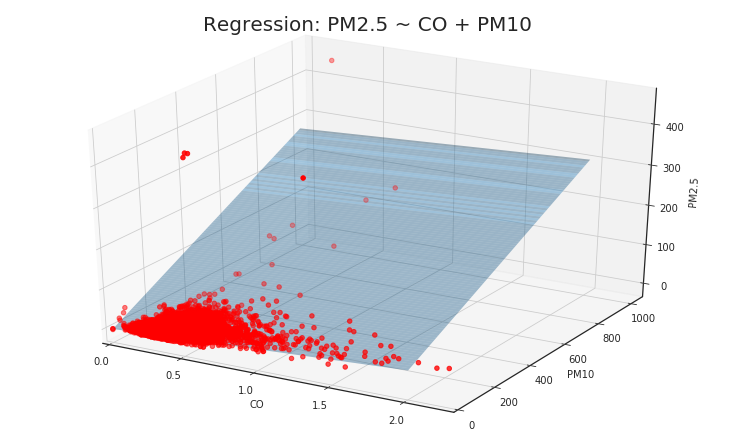

In [17]:
fig = plt.figure(figsize=(10, 6))
fig.suptitle('Regression: PM2.5 ~ CO + PM10', fontsize=20)

ax = axes3d.Axes3D(fig)

ax.plot_surface(B1, B2, Z, rstride=10, cstride=5, alpha=0.4)
ax.scatter3D(x1, x2, z, c='r')

ax.set_xlabel('CO')
ax.set_xlim(xmin=0)
ax.set_ylabel('PM10')
ax.set_ylim(ymin=0)
ax.set_zlabel('PM2.5');